# Plot max_like_sim

In [1]:
# %load first_cell.py
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"


def print_shape(*args):
    nelem = len(args)
    for ii in range(nelem - 1):
        print(args[ii].shape, end=" ")
    print(args[nelem - 1].shape)


def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder


path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

DEBUG:jupyter_black:Using config from /home/jchaves/Proyectos/projects/lya/cup1d/pyproject.toml
DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

/home/jchaves/Proyectos/projects/lya/cup1d/notebooks/


## Read Data

### Options

In [34]:
from cup1d.scripts.call_max_like_sim import Args
from cup1d.scripts.max_like_sim import fname_minimize
from cup1d.scripts.sam_like_sim import path_sampler
from matplotlib.ticker import MaxNLocator
from lace.archive import gadget_archive, nyx_archive
from cup1d.likelihood import lya_theory
from lace.cosmo.camb_cosmo import get_cosmology, get_camb_results, get_Nyx_cosmology
from lace.cosmo.fit_linP import parameterize_cosmology_kms

In [88]:
def get_fid_cosmo(archive):
    if archive.list_sim[0][:3] == "mpg":
        get_cosmo = get_cosmology
    else:
        get_cosmo = get_Nyx_cosmology
    z_star = 3.0
    kp_kms = 0.009
    arr_fid_cosmo = {}
    arr_fid_cosmo["Delta2_star"] = np.zeros((len(archive.list_sim)))
    arr_fid_cosmo["n_star"] = np.zeros((len(archive.list_sim)))
    for ii, sim in enumerate(archive.list_sim):
        ind = np.argwhere(archive.sim_label == sim)[0, 0]
        cosmo_fid = get_cosmo(
            H0=archive.data[ind]["cosmo_params"]["H0"],
            mnu=archive.data[ind]["cosmo_params"]["mnu"],
            omch2=archive.data[ind]["cosmo_params"]["omch2"],
            ombh2=archive.data[ind]["cosmo_params"]["ombh2"],
            omk=archive.data[ind]["cosmo_params"]["omk"],
            As=archive.data[ind]["cosmo_params"]["As"],
            ns=archive.data[ind]["cosmo_params"]["ns"],
            nrun=archive.data[ind]["cosmo_params"]["nrun"],
        )
        cosmo_model_fid = CAMB_model.CAMBModel(
            zs=archive.list_sim_redshifts,
            cosmo=cosmo_fid,
            z_star=z_star,
            kp_kms=kp_kms,
        )
        par = cosmo_model_fid.get_linP_params()
        arr_fid_cosmo["Delta2_star"][ii] = par["Delta2_star"]
        arr_fid_cosmo["n_star"][ii] = par["n_star"]
    return arr_fid_cosmo

In [3]:
# list of options to set
training_set = "Cabayol23"
emulator_label = "Cabayol23"
add_hires = False
# emulator_label = "Cabayol23_extended"
# add_hires = True
use_polyfit = True
cov_label = "Chabanier2019"
arr_drop_sim = [True, False]
arr_n_igm = [0, 1, 2, 3]
override = False

if (training_set == "Pedersen21") | (training_set == "Cabayol23"):
    list_sims = [
        "mpg_0",
        "mpg_1",
        "mpg_2",
        "mpg_3",
        "mpg_4",
        "mpg_5",
        "mpg_6",
        "mpg_7",
        "mpg_8",
        "mpg_9",
        "mpg_10",
        "mpg_11",
        "mpg_12",
        "mpg_13",
        "mpg_14",
        "mpg_15",
        "mpg_16",
        "mpg_17",
        "mpg_18",
        "mpg_19",
        "mpg_20",
        "mpg_21",
        "mpg_22",
        "mpg_23",
        "mpg_24",
        "mpg_25",
        "mpg_26",
        "mpg_27",
        "mpg_28",
        "mpg_29",
        "mpg_central",
        "mpg_seed",
        "mpg_growth",
        "mpg_neutrinos",
        "mpg_curved",
        "mpg_running",
        "mpg_reio",
    ]
elif training_set[:5] == "Nyx23":
    list_sims = [
        "nyx_0",
        "nyx_1",
        "nyx_2",
        "nyx_3",
        "nyx_4",
        "nyx_5",
        "nyx_6",
        "nyx_7",
        "nyx_8",
        "nyx_9",
        "nyx_10",
        "nyx_11",
        "nyx_12",
        "nyx_13",
        "nyx_14",
        "nyx_15",
        "nyx_16",
        "nyx_17",
        "nyx_central",
        "nyx_seed",
        "nyx_wdm",
    ]

In [4]:
emu_params = ["Delta2_p", "n_p", "mF", "sigT_Mpc", "gamma", "kF_Mpc"]
if training_set == "Pedersen21":
    archive = gadget_archive.GadgetArchive(postproc=training_set)
elif training_set == "Cabayol23":
    archive = gadget_archive.GadgetArchive(postproc=training_set)
elif training_set[:5] == "Nyx23":
    archive = nyx_archive.NyxArchive(nyx_version=training_set[6:])
    
fid_cosmo = get_fid_cosmo(archive)

### Load

<!-- # save = {
#     "metadata": out_args,
#     "best_chi2": best_chi2,
#     "name_parameters": free_parameters,
#     "truth_parameters": truth_values,
#     "best_parameters": best_fit_values,
#     "err_best_parameters": err_best_fit_values,
#     "covariance": np.array(minimizer.minimizer.covariance),
# } -->

#### Minimizer

In [83]:
arr_drop_sim = [True, False]
arr_n_igm = [0, 1, 2, 3]

# chi2, As, ns
chi2 = np.zeros((len(arr_drop_sim), len(arr_n_igm), len(list_sims)))
# diff_As, diff_ns
dat = np.zeros((len(arr_drop_sim), len(arr_n_igm), len(list_sims), 2))
# err_As, err_ns
err = np.zeros((len(arr_drop_sim), len(arr_n_igm), len(list_sims), 2))

for ii, drop_sim in enumerate(arr_drop_sim):
    for jj, n_igm in enumerate(arr_n_igm):
        for kk, sim_label in enumerate(list_sims):
            args = Args()

            args.training_set = training_set
            args.emulator_label = emulator_label
            args.add_hires = add_hires
            args.use_polyfit = use_polyfit
            args.cov_label = cov_label

            args.drop_sim = drop_sim
            args.n_igm = n_igm
            args.test_sim_label = sim_label

            fname = fname_minimize(args)
            file = np.load(fname, allow_pickle=True).item()            
            chi2[ii, jj, kk] = file["best_chi2"]
            diff = file["best_parameters"][:2] - file["truth_parameters"][:2]
            dat[ii, jj, kk] = diff
            err[ii, jj, kk] = file["err_best_parameters"][:2]

#### Sampler

In [92]:
def summary2array(summary, par_use):
    out = np.zeros((len(par_use), 3))
    ii = 0
    for par in file["summary"]:
        if par in par_use:
            out[ii, 0] = file["summary"][par].lower
            out[ii, 1] = file["summary"][par].center
            out[ii, 2] = file["summary"][par].upper
            ii += 1
    return out

In [107]:
# arr_drop_sim = [True]
# arr_n_igm = [0]
arr_drop_sim = [True, False]
arr_n_igm = [0, 1, 2]

par_use = ["$\\Delta^2_\\star$", "$n_\\star$"]

# chi2, As, ns
# chi2 = np.zeros((len(arr_drop_sim), len(arr_n_igm), len(list_sims)))
# diff_As, diff_ns
dat = np.zeros(
    (len(arr_drop_sim), len(arr_n_igm), len(list_sims), len(par_use), 3)
)
# err_As, err_ns
# err = np.zeros((len(arr_drop_sim), len(arr_n_igm), len(list_sims), 3))

for ii, drop_sim in enumerate(arr_drop_sim):
    for jj, n_igm in enumerate(arr_n_igm):
        for kk, sim_label in enumerate(list_sims):
            args = Args()

            args.training_set = training_set
            args.emulator_label = emulator_label
            args.add_hires = add_hires
            args.use_polyfit = use_polyfit
            args.cov_label = cov_label

            args.drop_sim = drop_sim
            args.n_igm = n_igm
            args.test_sim_label = sim_label

            fname = path_sampler(args) + "/chain_1/results.npy"
            file = np.load(fname, allow_pickle=True).item()

            #             chi2[ii, jj, kk] = file["best_chi2"]
            #             diff = file["best_parameters"][:2] - file["truth_parameters"][:2]
            dat[ii, jj, kk] = summary2array(file["summary"], par_use)
            dat[ii, jj, kk, 0] -= fid_cosmo["Delta2_star"][kk]
            dat[ii, jj, kk, 1] -= fid_cosmo["n_star"][kk]
#             err[ii, jj, kk] = file["err_best_parameters"][:2]

## Plot

#### minimizer

In [8]:
folder = os.environ["CUP1D_PATH"] + "/data/minimize/Cabayol23_lres/"

for ii in range(len(arr_drop_sim)):
    for jj in range(len(arr_n_igm)):
        samples = list_sims
        values1 = dat[ii, jj, :, 0] * 1e8
        err1 = np.sqrt(err[ii, jj, :, 0] * 1e8)
        values2 = dat[ii, jj, :, 1]
        err2 = np.sqrt(err[ii, jj, :, 1])
        values3 = chi2[ii, jj, :]

        fig, ax = plt.subplots(1, 3, sharey=True, figsize=(5, 10))

        # Create a scatter plot with two points for each sample
        ax[0].errorbar(
            values1, samples, yerr=None, xerr=err1, ls="", marker="o"
        )
        #         ax[0].scatter(values1, samples, marker="o", color="r")
        ax[1].errorbar(
            values2, samples, yerr=None, xerr=err2, ls="", marker="o"
        )

        #         ax[1].scatter(values2, samples)
        ax[2].scatter(values3, samples)
        lvls = [-0.05, 0, 0.05]
        lss = [":", "--", ":"]
        for ls, lvl in zip(lss, lvls):
            ax[0].axvline(lvl, ls=ls, color="k")
            ax[1].axvline(lvl, ls=ls, color="k")
        lvls = [1, 10, 100]
        for lvl in lvls:
            ax[2].axvline(lvl, ls="--", color="k")
        ax[0].set_xlabel(r"$\Delta A_s \times 10^8$")
        ax[1].set_xlabel(r"$\Delta n_s$")
        ax[2].set_xlabel(r"$\chi^2$")
        ax[2].set_xscale("log")
        ax[0].set_xlim([-0.1, 0.1])
        ax[1].set_xlim([-0.1, 0.1])
        ax[2].set_xlim([0.1, 1e3])

        if arr_drop_sim[ii]:
            flag = "leave 1 out,"
            flag2 = "yl1O"
        else:
            flag = "no leave 1 out,"
            flag2 = "nl1O"

        plt.suptitle(flag + " n_igm=" + str(arr_n_igm[jj]))
        plt.tight_layout()
        #         plt.savefig(folder + flag2 + "nigm" + str(arr_n_igm[jj]) + ".png")
        break
    break

NameError: name 'err' is not defined

### sampler

<IPython.core.display.Javascript object>


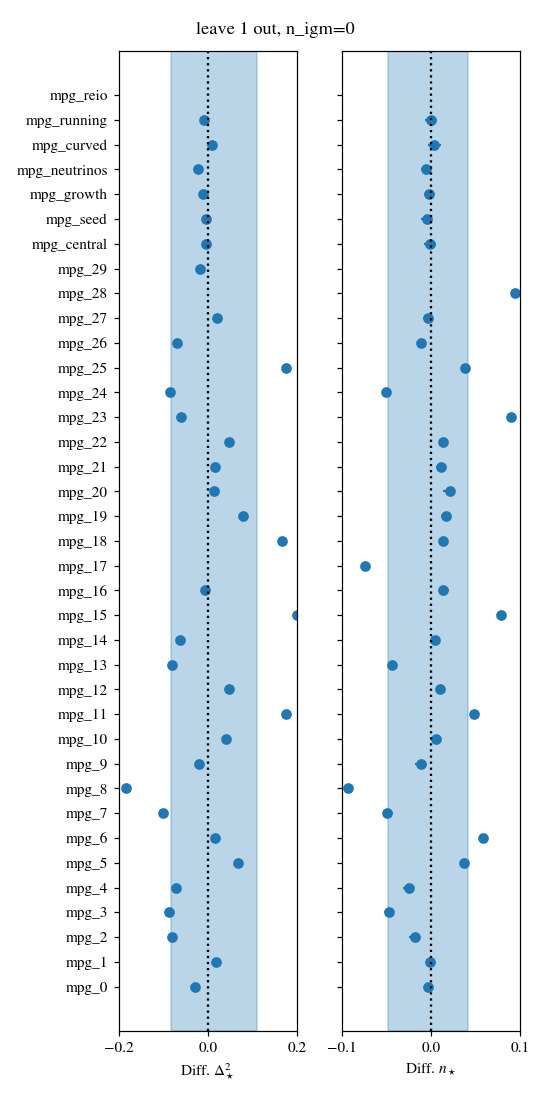

<IPython.core.display.Javascript object>


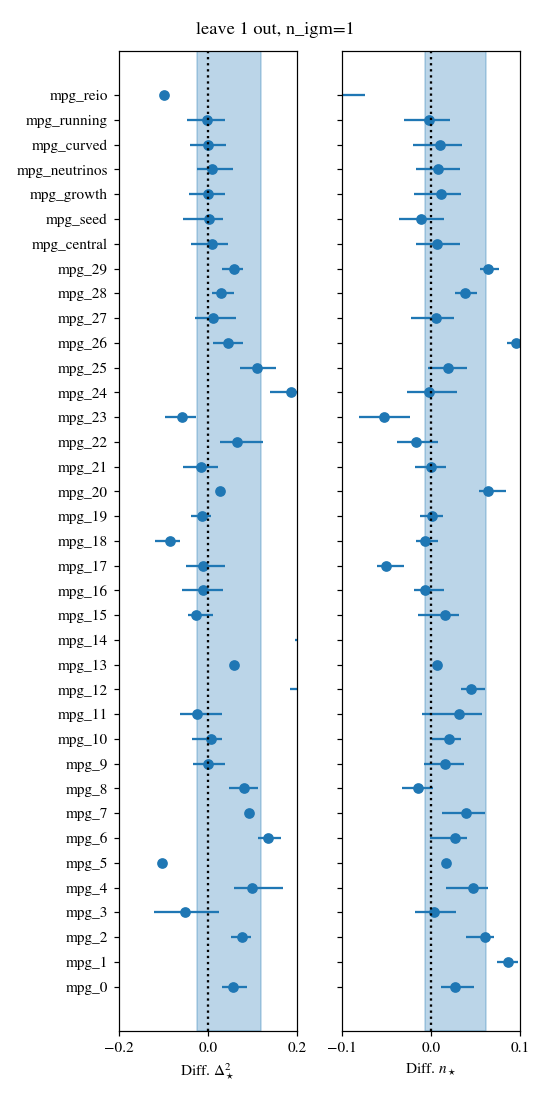

<IPython.core.display.Javascript object>


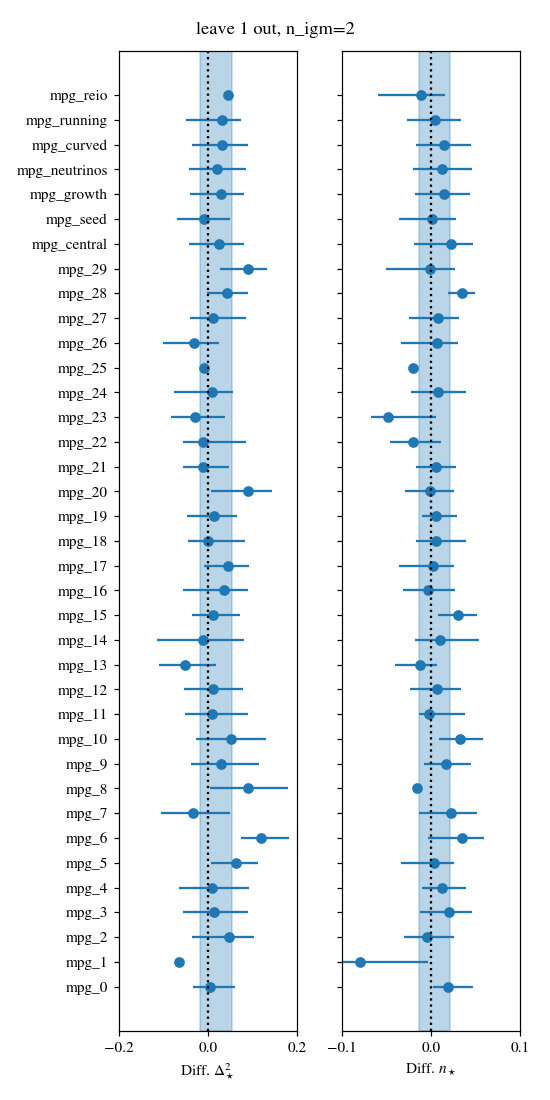

<IPython.core.display.Javascript object>


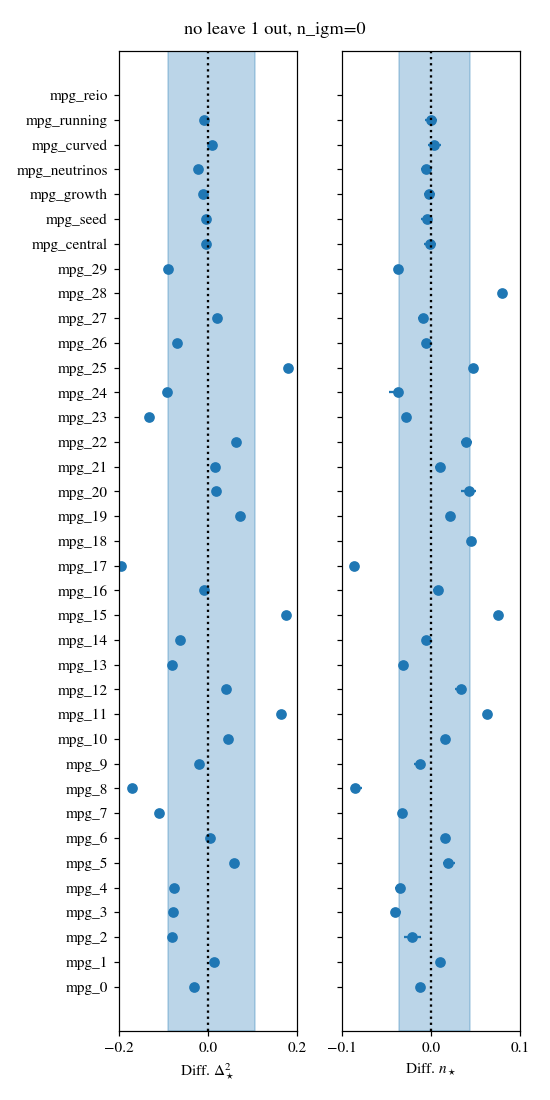

<IPython.core.display.Javascript object>


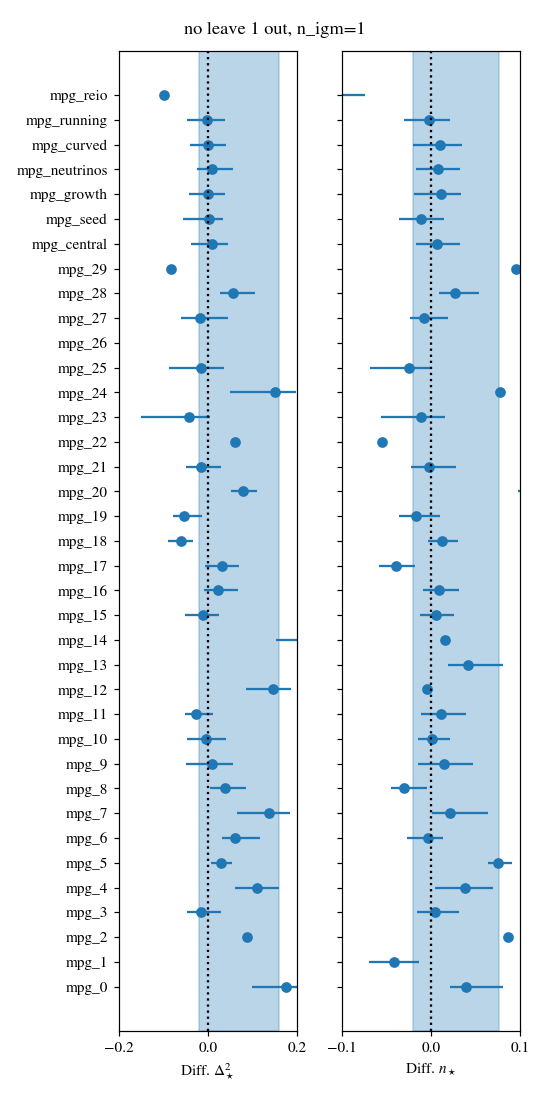

<IPython.core.display.Javascript object>


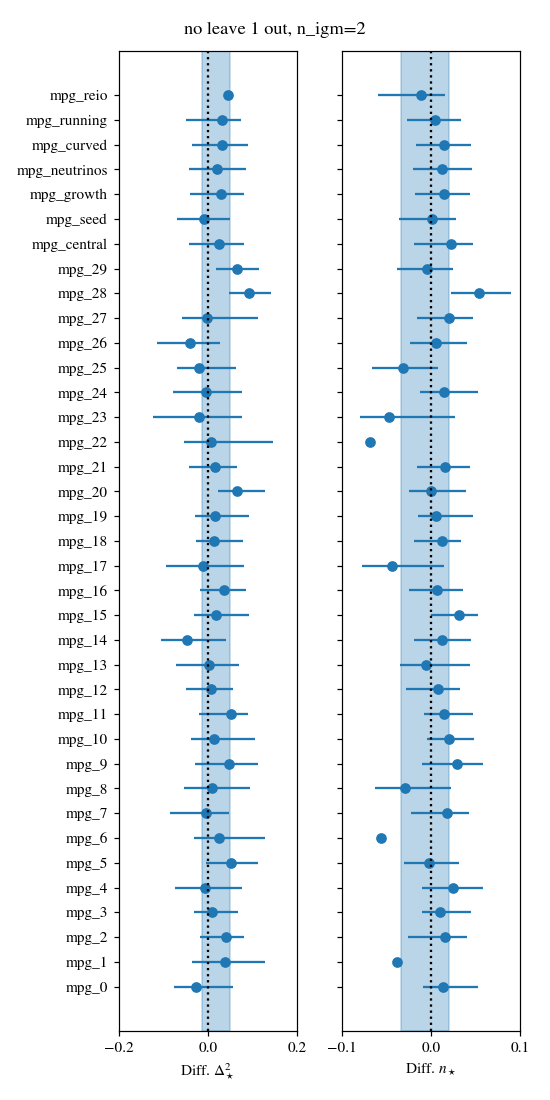

In [130]:
folder = (
    os.path.dirname(os.environ["CUP1D_PATH"]) + "/data/cup1d/sampler/figs/"
)

lab_par_use = []
for par in par_use:
    lab_par_use.append("Diff. " + par)

for ii in range(len(arr_drop_sim)):
    for jj in range(0, 3):
        samples = np.array(list_sims)

        fig, ax = plt.subplots(1, 2, sharey=True, figsize=(5, 10))

        # Create a scatter plot with two points for each sample
        for kk in range(2):
            values = dat[ii, jj, :, kk, :]
            xerr = np.array(
                [values[:, 1] - values[:, 0], values[:, 2] - values[:, 1]]
            )
            ax[kk].plot(
                values[:, 1],
                samples,
                ls="",
                color="C0",
                marker="o",
            )
            #             _ = np.isfinite(xerr[0, :])
            ax[kk].errorbar(
                values[:, 1],
                samples[:],
                xerr=xerr[:, :],
                color="C0",
                ls="",
                #                 marker="o",
            )
            std_values = np.percentile(
                values[: len(archive.list_sim_cube), 1], [16, 84]
            )
            ax[kk].axvspan(std_values[0], std_values[1], alpha=0.3, color="C0")
            #             ax[kk].scatter(values, samples, marker="o", color="r")
            ax[kk].set_xlabel(lab_par_use[kk])
            if kk == 0:
                ax[kk].set_xlim([-0.2, 0.2])
            else:
                ax[kk].set_xlim([-0.1, 0.1])

            ax[kk].axvline(0, ls=":", color="k")

        if arr_drop_sim[ii]:
            flag = "leave 1 out,"
            flag2 = "flag2_yl1O"
        else:
            flag = "no leave 1 out,"
            flag2 = "flag2_nl1O"

        plt.suptitle(flag + " n_igm=" + str(arr_n_igm[jj]))
        plt.tight_layout()
        plt.savefig(
            folder + "png/" + flag2 + "_nigm" + str(arr_n_igm[jj]) + ".png"
        )
        plt.savefig(
            folder + "pdf/" + flag2 + "_nigm" + str(arr_n_igm[jj]) + ".pdf"
        )
#         break
#     break

30

In [124]:
values.shape

(37, 3)